# Test hypothesis that EfeU is fragmented in the same way across all strains
# Null: EfeU fragmentation does not follow an observable consistent pattern

### PATRIC CLI commands
#### Final command:
`p3-get-feature-data < efeU_products_all.tbl --attr na_sequence --col=feature.patric_id > efeU_seqs_all.tbl`

where efeU_products_all.tbl created from downloaded table of efeU ids (faster than using API for that first step).

#### Other potentially useful commands
- `p3-all-genomes --eq "genome_name,Escherichia`
- `p3-get-genome-features --eq product,efeU`
- `p3-get-genome-features --eq feature_type,CDS --attr patric_id,sequence_id,location,product >features.tbl`
- `p3-get-feature-data --attr na_sequence --col=feature.patric_id`

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

%matplotlib inline

### Load PATRIC result and filter out some rows

In [4]:
COL_ID = 'Genome ID'

In [5]:
patric = pd.read_csv('/home/laurence/ME/data/Amitesh/PATRIC_genome_feature_efeU.csv', dtype={'Genome ID':object})
exclude_genomes = ['Escherichia coli', 'Escherichia coli DSM 30083 = JCM 1649 = ATCC 11775']
patric = patric[~patric.Genome.isin(exclude_genomes)]   # want specific strains
print(patric.shape)

(12626, 21)


In [6]:
def split_names(x):
    genome = x['Genome']
    substrs = genome.split(' ')
    genus = substrs[0].strip()
    species = substrs[1].strip()
    k = 3
    strain = substrs[2].strip()
    if strain=='strain' or strain=='str.':
        strain = substrs[3]
        k = 4    
    sub = ' '.join(substrs[k:]) if len(substrs)>k else ''
    return pd.Series({
        'Genome ID':x['Genome ID'],
        'genus':genus, 'species':species, 'strain':strain, 'sub':sub
    })

df_names = patric[['Genome','Genome ID']].drop_duplicates()
sub_names = df_names.apply(split_names, axis=1)

sub_names.species.unique()
sub_names[ sub_names.species=='marmotae']

sub_names.species.unique()

keep_species = ['coli'] #,'sp.']
ecoli_names = sub_names[ sub_names.species.isin(keep_species)]
ecoli_names['Genome ID'].unique().shape

# ecoli_names.to_csv('only_ecoli_names.csv', index=False)

(12117,)

In [7]:
ecoli_ids = ecoli_names['Genome ID'].unique()
print("E coli: %d"%len(ecoli_ids))

patric = patric[ patric['Genome ID'].isin(ecoli_ids)]
patric.shape

E coli: 12117


(12479, 21)

In [8]:
#efeU_table = patric[['Genome ID','PATRIC ID','RefSeq Locus Tag','Feature ID','Feature Type','Gene Symbol','Product']]
efeU_table = patric[['Genome ID','PATRIC ID','RefSeq Locus Tag','Product']]
efeU_table.rename(columns={'Genome ID':'genome.genome_id', 'PATRIC ID':'feature.patric_id', 
                           'RefSeq Locus Tag':'feature.refseq_locus_tag', 'Product':'feature.product'}, inplace=True)

### WRITE TO FILE -- already did it
#efeU_table.to_csv('efeU_products_all.tbl', sep='\t', index=False)

/usr/lib/python2.7/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


## Check for all possible deletions bringing stop codon in frame

In [9]:
import re
from six import iteritems

stop_codons = ['tga','tag','taa']

def frameshift_sequence(seq, i):
    i1 = max(0,i)
    i2 = i+1
    seq2 = seq[0:i1] + seq[i2:]
    return seq2

def enum_fragment_locs(seq, simple_output=True):
    """
    Enumerate all locations where frameshift would
    bring stop codon in frame
    """    
    seq_len = len(seq)
    seq_dict = {}
    for i in range(3,seq_len-1):
        seq2 = frameshift_sequence(seq,i)        
        ### Check 3 at a time
        stop_dict = {}
        for j in range(0,len(seq2),3):
            cod = seq2[j:(j+3)]
            if len(cod)==3 and cod in stop_codons:
                stop_dict[j]=cod        
        seq_dict[i] = stop_dict

    if simple_output:
        locs = [idel for idel,vdel in iteritems(seq_dict) if len(vdel)>0]
        return locs
    else:
        return seq_dict

### QUICK TEST

In [10]:
sb = 'atgtacggg'.lower()
print(enum_fragment_locs(sb, simple_output=False))
enum_fragment_locs(sb)

{3: {}, 4: {}, 5: {3: 'tag'}, 6: {}, 7: {}}


[5]

In [12]:
df_seqs = pd.read_csv('../efeU_seqs_all.tbl', sep='\t')
df_seqs.loc[:,'genome.genome_id'] = df_seqs['genome.genome_id'].apply(str)
df_seqs.loc[:,'length'] = df_seqs['feature.na_sequence'].apply(len)

In [13]:
import pandas as pd
import numpy as np

dsplot_frag = df_seqs[ df_seqs.length < 831]
dsplot_frag = dsplot_frag.sort_values('length')
dsplot = dsplot_frag.groupby('genome.genome_id').apply(lambda x: pd.Series({
    'n_fragments':len(x['length']),
    'fragment1':x['length'].min(),
    'fragment2':x['length'].max() if len(x['length'])>1 else np.nan,
    'total_length':x['length'].sum()
})).reset_index()
print(dsplot.n_fragments.unique())
dsplot = dsplot.sort_values('fragment1')
dsplot.shape

[1. 2. 3. 4.]


(376, 5)

In [14]:
print len(dsplot['genome.genome_id'].unique())
print len(dsplot[dsplot.n_fragments==2]['genome.genome_id'].unique())

376
234


In [15]:
k12_ids = patric[ patric['Genome'].str.contains('MG1655')]['Genome ID'].unique()
dsplot[ dsplot['genome.genome_id'].isin(k12_ids)]

,genome.genome_id,fragment1,fragment2,n_fragments,total_length
375,879462.4,120.0,720.0,2.0,840.0
327,562.7808,120.0,720.0,2.0,840.0
328,562.7809,120.0,720.0,2.0,840.0
67,511145.616,120.0,720.0,2.0,840.0
68,511145.648,120.0,720.0,2.0,840.0
66,511145.209,120.0,720.0,2.0,840.0
60,511145.182,120.0,720.0,2.0,840.0
61,511145.183,120.0,720.0,2.0,840.0
57,511145.12,120.0,720.0,2.0,840.0
62,511145.184,120.0,720.0,2.0,840.0


In [16]:
dsplot2 = dsplot[ dsplot.n_fragments==2]
from __future__ import division

n1s =dsplot2.fragment1.unique()
for n1 in n1s:
    dfi = dsplot2[ dsplot2.fragment1==n1]
    ntotmin = dfi.total_length.min()
    ntotmax = dfi.total_length.max()    
    print("Total lengths: %d--%d.\tLength 1 = %d. (%d / %d =%.3g%%)" % (ntotmin,ntotmax,n1, dfi.shape[0], dsplot2.shape[0], 100*dfi.shape[0]/dsplot2.shape[0]))
    #print(n1, dfi.shape[0])

Total lengths: 819--819.	Length 1 = 99. (2 / 234 =0.855%)
Total lengths: 918--918.	Length 1 = 111. (1 / 234 =0.427%)
Total lengths: 825--825.	Length 1 = 117. (4 / 234 =1.71%)
Total lengths: 840--840.	Length 1 = 120. (161 / 234 =68.8%)
Total lengths: 618--657.	Length 1 = 132. (2 / 234 =0.855%)
Total lengths: 777--777.	Length 1 = 135. (1 / 234 =0.427%)
Total lengths: 921--921.	Length 1 = 141. (1 / 234 =0.427%)
Total lengths: 297--297.	Length 1 = 147. (1 / 234 =0.427%)
Total lengths: 384--384.	Length 1 = 162. (1 / 234 =0.427%)
Total lengths: 723--1005.	Length 1 = 177. (14 / 234 =5.98%)
Total lengths: 789--789.	Length 1 = 186. (1 / 234 =0.427%)
Total lengths: 807--807.	Length 1 = 189. (1 / 234 =0.427%)
Total lengths: 705--705.	Length 1 = 195. (1 / 234 =0.427%)
Total lengths: 801--807.	Length 1 = 198. (5 / 234 =2.14%)
Total lengths: 702--819.	Length 1 = 216. (2 / 234 =0.855%)
Total lengths: 834--834.	Length 1 = 231. (2 / 234 =0.855%)
Total lengths: 855--855.	Length 1 = 237. (1 / 234 =0.427%

In [17]:
print(dsplot2.fragment2.min(), dsplot2.fragment2.max())

(150.0, 828.0)


In [18]:
n2s = sorted(dsplot2.fragment2.unique())
for n2 in n2s:
    dfi = dsplot2[ dsplot2.fragment2==n2]
    ntotmin = dfi.total_length.min()
    ntotmax = dfi.total_length.max()    
    print("Total lengths: %d--%d.\tLength 2 = %d. (%d / %d =%.3g%%)" % (ntotmin,ntotmax,n2, dfi.shape[0], dsplot2.shape[0], 100*dfi.shape[0]/dsplot2.shape[0]))

Total lengths: 297--297.	Length 2 = 150. (1 / 234 =0.427%)
Total lengths: 384--384.	Length 2 = 222. (1 / 234 =0.427%)
Total lengths: 531--531.	Length 2 = 285. (1 / 234 =0.427%)
Total lengths: 750--750.	Length 2 = 381. (1 / 234 =0.427%)
Total lengths: 672--672.	Length 2 = 429. (1 / 234 =0.427%)
Total lengths: 774--774.	Length 2 = 441. (1 / 234 =0.427%)
Total lengths: 894--894.	Length 2 = 468. (1 / 234 =0.427%)
Total lengths: 789--831.	Length 2 = 471. (3 / 234 =1.28%)
Total lengths: 618--744.	Length 2 = 486. (3 / 234 =1.28%)
Total lengths: 861--861.	Length 2 = 492. (1 / 234 =0.427%)
Total lengths: 834--834.	Length 2 = 501. (1 / 234 =0.427%)
Total lengths: 807--807.	Length 2 = 507. (1 / 234 =0.427%)
Total lengths: 705--705.	Length 2 = 510. (1 / 234 =0.427%)
Total lengths: 657--657.	Length 2 = 525. (1 / 234 =0.427%)
Total lengths: 846--846.	Length 2 = 537. (1 / 234 =0.427%)
Total lengths: 723--879.	Length 2 = 546. (8 / 234 =3.42%)
Total lengths: 918--918.	Length 2 = 549. (1 / 234 =0.427%)


In [19]:
dsplot2.n_fragments.unique()

array([2.])

In [20]:
dsplotm = dsplot2[['genome.genome_id','fragment1','fragment2']].melt(id_vars='genome.genome_id')
dsplotm.head(2)

,genome.genome_id,variable,value
0,562.22905,fragment1,99.0
1,562.23196,fragment1,99.0


/usr/lib/python2.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


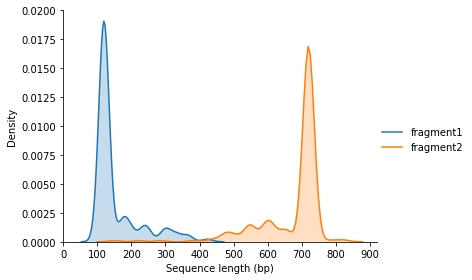

In [21]:
g = sns.FacetGrid(dsplotm, hue='variable', size=4, aspect=1.33)
g.map(sns.kdeplot, 'value', shade=True)
g.set_xlabels('Sequence length (bp)')
g.set_ylabels('Density')
g.set(xticks=range(0,1000,100))
g.add_legend(title='')
# g.savefig('/home/laurence/ME/figures/efeU/density_2_fragments_R01_062818.svg')
# g.savefig('/home/laurence/ME/figures/efeU/density_2_fragments_R01_062818.pdf')
# g.savefig('/home/laurence/ME/figures/efeU/density_2_fragments_R01_062818.png')

In [ ]:
%%time
rows = []
for ir,row in df_seqs.iterrows():
    seq = row['feature.na_sequence']
    frag_locs = enum_fragment_locs(seq)    
    rows.append({'Genome ID':str(row['genome.genome_id']),
                 'PATRIC ID':row['feature.patric_id'],
                 'Fragment_locs':frag_locs})
        
df_frag = pd.DataFrame(rows)

In [ ]:
df_result = pd.merge(df_frag, patric, on=['Genome ID','PATRIC ID'])

In [ ]:
last_stops = df_result[ df_result.Length.isin([830,831])].Fragment_locs.apply(lambda x: len(x))
print(last_stops).unique()
last_stops.hist()

In [ ]:
nonfrag_gids = df_result.loc[ frag_locs=='', 'Genome ID']
df_nonfrag = df_seqs[ df_seqs['genome.genome_id'].isin(nonfrag_gids)]
len(df_nonfrag[ df_nonfrag.length>=830]['genome.genome_id'].unique())

In [ ]:
df_result.loc[:,'frag_locs'] = df_result.Fragment_locs.apply(lambda x: ','.join([str(xi) for xi in x]))

In [ ]:
df_res_full = df_result[ df_result.Length >= 830]
df_res_full.shape

In [ ]:
df_res_full[df_res_full.frag_locs == ''].shape

In [ ]:
df_res_full[df_res_full.frag_locs != ''].shape

In [ ]:
set([len(s) for s in df_res_full.Fragment_locs])

In [ ]:
nonfrag_gids= df_res_full[ df_res_full.frag_locs=='']['Genome ID'].unique()

In [ ]:
df_meta = pd.read_csv('/home/laurence/ME/data/Amitesh/PATRIC_genome.csv', dtype={'Genome ID':object})

In [ ]:
df_nonfrag_meta = df_meta[ df_meta['Genome ID'].isin(nonfrag_gids)]
# df_nonfrag_meta.to_csv('/home/laurence/ME/data/Amitesh/no_stopcodon_meta.csv', index=False)

# Check if bias in fragmentation due to phylogeny vs. actual evolutionary trend

In [22]:
from Bio import Phylo
tree = Phylo.read('/home/laurence/ME/data/Amitesh/PATRIC_phylogeny_tree.nwk', 'newick')

In [23]:
term_clades = tree.get_terminals()
len(term_clades)

1018

In [24]:
clade_names = [c.name for c in term_clades]
dsplot[ dsplot['genome.genome_id'].isin(clade_names)].shape

(20, 5)

In [25]:
tree.distance('478005.5', '199310.4')

0.011196544699999998

In [26]:
from Bio import Phylo
tree = Phylo.read('/home/laurence/ME/data/Amitesh/PATRIC_phylogeny_tree_nissle.nwk', 'newick')
term_clades = tree.get_terminals()
print(len(term_clades))
clade_names = [c.name for c in term_clades]
dsplot[ dsplot['genome.genome_id'].isin(clade_names)].shape
print(tree.distance('478005.5', '199310.4'))

1018
0.0111965447


In [27]:
ids120 = dsplot[ dsplot.fragment1==120]['genome.genome_id'].unique()
len(ids120)

161

# A: Simple first pass

In [28]:
frag_names = pd.merge(dsplot.rename(columns={'genome.genome_id':'Genome ID'}), sub_names, on='Genome ID')
frag_names = frag_names[frag_names.species=='coli']
frag_names.head()

,Genome ID,fragment1,fragment2,n_fragments,total_length,genus,species,strain,sub
0,562.10529,81.0,591.0,4.0,1161.0,Escherichia,coli,32122,
1,562.18844,93.0,492.0,3.0,717.0,Escherichia,coli,MOD1-EC5454,
2,562.22905,99.0,720.0,2.0,819.0,Escherichia,coli,O2:H1,strain ECO0512
3,562.23196,99.0,720.0,2.0,819.0,Escherichia,coli,O2:H1,strain ECO0818
4,562.28184,105.0,552.0,4.0,1309.0,Escherichia,coli,SP-16,Combo


In [29]:
frag_group = frag_names.groupby('strain').apply(lambda x: pd.Series({
    'frag1_min':x['fragment1'].min(),
    'frag1_max':x['fragment1'].max(),
    'frag1_avg':x['fragment1'].mean(),
    'count':len(x['fragment1'])
})).reset_index()

/usr/lib/python2.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/lib/python2.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Text(0.5,1,'Genomes with 120 bp Fragment 1')

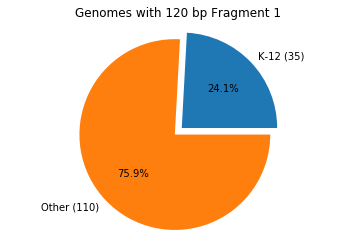

In [30]:
#frag_group[ frag_group.frag1_avg==120]
dfsum = frag_group[ frag_group.frag1_avg==120]
dfsum.loc[:,'label'] = dfsum.strain
dfsum.loc[ dfsum.label != 'K-12','label'] = 'Other'
dfsum = dfsum.groupby('label').agg({'count':sum, 'frag1_avg':min, 'frag1_min':min, 'frag1_max':min}).reset_index()
dfsum.loc[:,'strain'] = dfsum.label
labels = dfsum.label.values
labels[ dfsum.strain=='K-12'] = 'K-12 (%d)'%(dfsum[dfsum.strain == 'K-12']['count'].sum())
labels[ dfsum.strain!='K-12'] = 'Other (%d)'%(dfsum[dfsum.strain != 'K-12']['count'].sum())
# labels[ labels != 'K-12'] = ''
nstrains= dfsum.shape[0]
explode = np.zeros(nstrains)
explode[ dfsum.strain=='K-12'] = 0.1
plt.pie('count', labels=labels, autopct="%1.1f%%", data=dfsum, explode=explode)
plt.axis('equal')
plt.title('Genomes with 120 bp Fragment 1')

In [32]:
df234 = dsplot[dsplot.n_fragments==2]
df234.to_csv('../df234.csv',index=False)